# Crafting summary Statistics

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch

from sbi.inference import NPE
from sbi.analysis import pairplot
from sbi.utils import BoxUniform

In [2]:
# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

In [3]:
prior_min = [-1, -1, -1]
prior_max = [1, 1, 1]
prior = BoxUniform(
    low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max)
)

In [4]:
def create_t_x(theta, seed=None):
    """Return an t, x array for plotting based on params"""
    if theta.ndim == 1:
        theta = theta[np.newaxis, :]

    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    t = np.linspace(-1, 1, 200)
    ts = np.repeat(t[:, np.newaxis], theta.shape[0], axis=1)
    x = (
        theta[:, 0] * ts**2
        + theta[:, 1] * ts
        + theta[:, 2]
        + 0.01 * rng.randn(ts.shape[0], theta.shape[0])
    )
    return t, x


def eval(theta, t, seed=None):
    """Evaluate the quadratic function at `t`"""

    if theta.ndim == 1:
        theta = theta[np.newaxis, :]

    rng = np.random.RandomState(seed) if seed is not None else np.random.RandomState()

    return theta[:, 0] * t**2 + theta[:, 1] * t + theta[:, 2] + 0.01 * rng.randn(1)

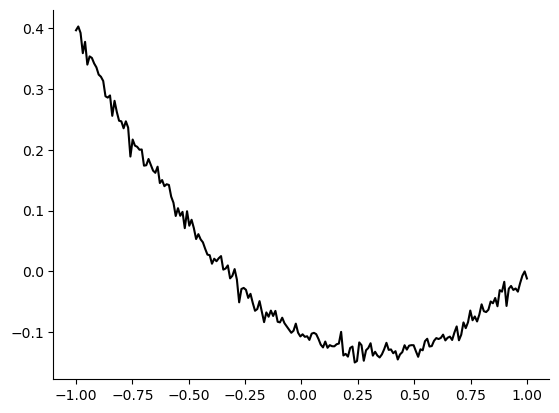

In [5]:
theta_o = np.array([0.3, -0.2, -0.1])
t, x = create_t_x(theta_o)
plt.plot(t, x, "k");

In [6]:
# Obtaining summary statistics using two methods:

def get_3_values(theta, seed=None):
    """
    Return 3 'x' values corresponding to t=-0.5,0,0.75 as summary statistic vector
    """
    return np.array(
        [
            eval(theta, -0.5, seed=seed),
            eval(theta, 0, seed=seed),
            eval(theta, 0.75, seed=seed),
        ]
    ).T

In [7]:
def get_MSE(theta, theta_o, seed=None):
    """
    Return the mean-squared error (MSE) i.e. Euclidean distance from the
    observation function
    """
    _, x = create_t_x(theta_o, seed=seed)  # truth
    _, x_ = create_t_x(theta, seed=seed)  # simulations
    return np.mean(np.square(x_ - x), axis=0, keepdims=True).T  # MSE

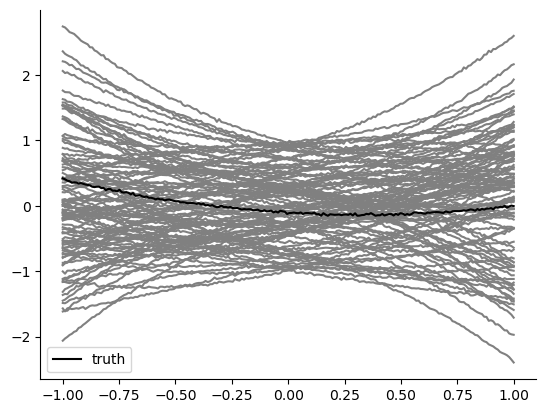

In [8]:
t, x_truth = create_t_x(theta_o)
plt.plot(t, x_truth, "k", zorder=1, label="truth")
n_samples = 100
theta = prior.sample((n_samples,))
t, x = create_t_x(theta.numpy())
plt.plot(t, x, "grey", zorder=0)
plt.legend()

In [9]:
# Using MSE

theta = prior.sample((1000,))
x = get_MSE(theta.numpy(), theta_o)

theta = torch.as_tensor(theta, dtype=torch.float32)
x = torch.as_tensor(x, dtype=torch.float32)

In [10]:
inference = NPE(prior)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 432 epochs.

In [11]:
x_o = torch.as_tensor(
    [
        [
            0.0,
        ]
    ]
)
theta_p = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

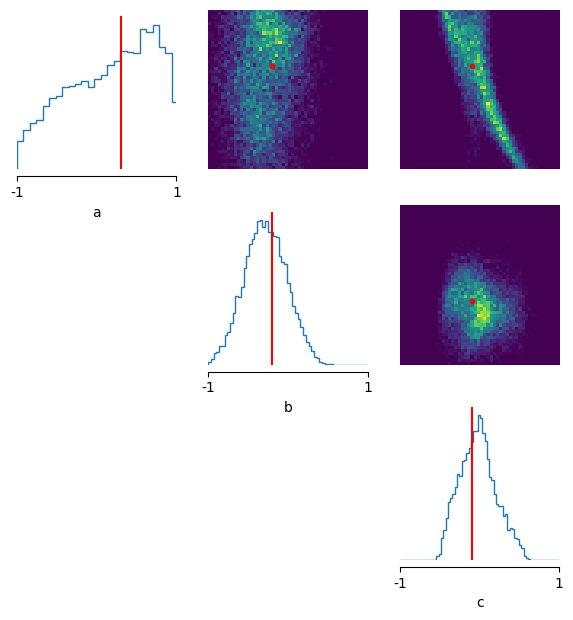

In [12]:
fig, axes = pairplot(
    theta_p,
    limits=list(zip(prior_min, prior_max)),
    ticks=list(zip(prior_min, prior_max)),
    figsize=(7, 7),
    labels=["a", "b", "c"],
    fig_kwargs=dict(
        points_offdiag={"markersize": 6},
        points_colors="r",
    ),
    points=theta_o,
);

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

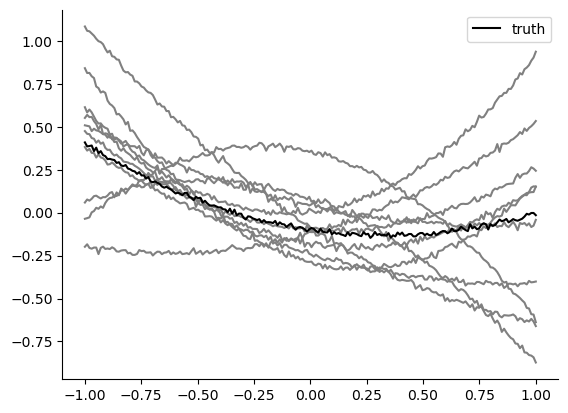

In [13]:
x_o_t, x_o_x = create_t_x(theta_o)
plt.plot(x_o_t, x_o_x, "k", zorder=1, label="truth")

theta_p = posterior.sample((10,), x=x_o)
x_t, x_x = create_t_x(theta_p.numpy())
plt.plot(x_t, x_x, "grey", zorder=0)
plt.legend();

In [14]:
# Using 3 coordinates as summary statistics

x = get_3_values(theta.numpy())
x = torch.as_tensor(x, dtype=torch.float32)

In [15]:
inference = NPE(prior)

_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

 Neural network successfully converged after 375 epochs.

In [16]:
x_o = torch.as_tensor(get_3_values(theta_o), dtype=float)

In [17]:
x_o

tensor([[ 0.0666, -0.1046, -0.0741]], dtype=torch.float64)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

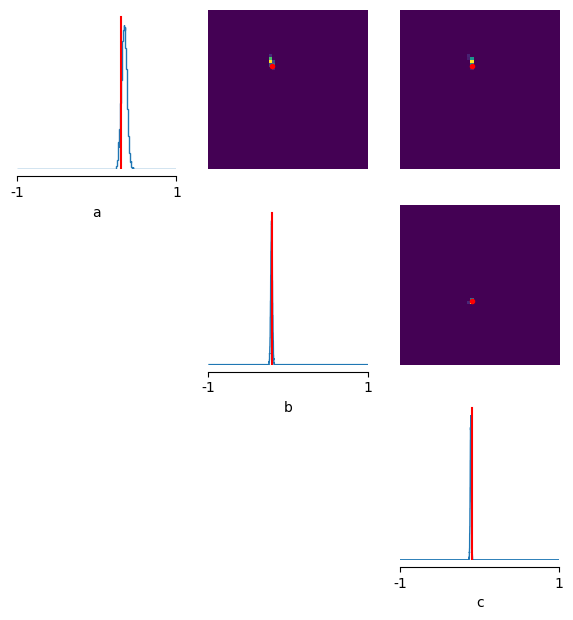

In [18]:
theta_p = posterior.sample((10000,), x=x_o)

fig, axes = pairplot(
    theta_p,
    limits=list(zip(prior_min, prior_max)),
    ticks=list(zip(prior_min, prior_max)),
    figsize=(7, 7),
    labels=["a", "b", "c"],
    fig_kwargs=dict(
        points_offdiag={"markersize": 6},
        points_colors="r",
    ),
    points=theta_o,
);

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

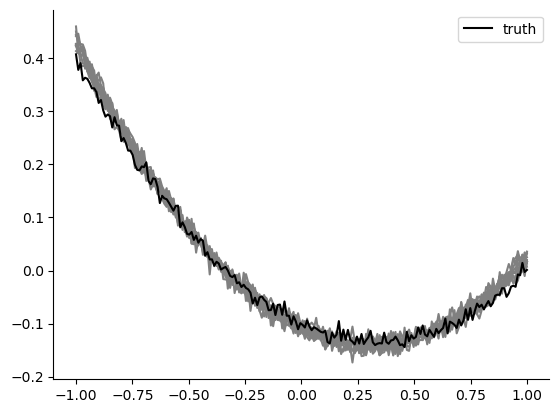

In [19]:
x_o_t, x_o_x = create_t_x(theta_o)
plt.plot(x_o_t, x_o_x, "k", zorder=1, label="truth")
theta_p = posterior.sample((100,), x=x_o)
ind_10_highest = np.argsort(np.array(posterior.log_prob(theta=theta_p, x=x_o)))[-10:]
theta_p_considered = theta_p[ind_10_highest, :]
x_t, x_x = create_t_x(theta_p_considered.numpy())
plt.plot(x_t, x_x, "grey", zorder=0)
plt.legend()